   # Obstacle Avoidance with Differential Drive robots

Let us try to use optimal control to compute optimal trajectories for a **differential drive** robot that must **reach a target** while **avoiding collisions** with static obstacles.

## Modeling a Differential Drive Robot
The state of a differential robot is typically defined by its 2D position $(p_x, p_y)$ and its orientation on the plane $\theta$:
$$ x = [p_x, p_y, \theta]$$

The control inputs are the linear velocity $v$ and the angular velocity $\omega$:
$$ u = [v, \omega]$$

Its dynamics is defined by the following nonlinear differential equations:
$$ \dot{p}_x = v \cos(\theta)$$
$$ \dot{p}_y = v \sin(\theta)$$
$$ \dot{\theta} = \omega $$

Let's define the dynamics function using Casadi.

In [1]:
import casadi as cs

nx = 3 # size of state vector x
nu = 2 # size of control vector u

# create the dynamics function
x   = cs.SX.sym('x', nx) # x = [px, py, theta]
u   = cs.SX.sym('u', nu) # u = [v, w]
rhs    = cs.vertcat(cs.cos(x[-1])*u[0], 
                    cs.sin(x[-1])*u[0], 
                    u[1])
f = cs.Function('f', [x, u], [rhs])

# Trajectory optimization problem

Let us create a base problem to reach a state $x_{des}$ in a given time horizon $N$, while minimizing the control inputs $u$ in squared norm.
$$ \min_{X, U} \quad \sum_{k=0}^{N-1} w_u ||u_k||^2 + ||x_{N} - x_{des}||^2$$
$$ \text{subject to} \quad x_{k+1} = f(x_k, u_k) \quad \forall k=0, \dots, N-1$$
$$ \qquad \qquad\, u_{min} \le u_{k} \le u_{max} \quad \forall k=0, \dots, N-1$$

In [2]:
def create_base_problem(x_init, x_des, u_min, u_max, w_u, N, dt):
    opti = cs.Opti()

    # Create all decision variables for state and control
    X, U = [], []
    for k in range(N+1): 
        X += [opti.variable(nx)]
    for k in range(N): 
        U += [opti.variable(nu)]
        opti.subject_to( opti.bounded(u_min, U[-1], u_max) )

    # Add initial conditions
    opti.subject_to(X[0] == x_init)

    # Add cost function and dynamics constraints
    cost = 0
    for k in range(N):     
        cost += w_u * U[k].T @ U[k]
        opti.subject_to(X[k+1] == X[k] + dt * f(X[k], U[k]))

    # Add terminal cost
    cost += (X[-1] - x_des).T @ (X[-1] - x_des)
    opti.minimize(cost)

    # create the optimization solver
    opti.solver("ipopt", {"ipopt.print_level": 0, "print_time": 0})
    
    return opti, X, U

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import time
from ipywidgets import interact, FloatSlider

dt = 0.1                           # time step
N = 25                             # time horizon
x_init = np.zeros(nx)              # initial state
w_u = 1e-4                         # control weight
u_min = -2*np.ones(nu)             # minimum value of u
u_max = 2*np.ones(nu)              # maximum value of u
robot_ray = 0.1                    # ray of the robot used for visualization

In [4]:
def plot_robot(x, ray, color1='r', color2='k', fill=1, axis=None):
    # x: 3d vector containing x, y and theta of the robot
    # ray: length of the ray of the robot
    # color1: color for the circle
    # color2: color for the rectangle
    # fill: if 1 the circle is filled with the color
    px, py, theta = x[0], x[1], x[2]
    if(axis is None):
        axis = plt.gca()
    axis.add_patch(plt.Circle((px, py), ray, color=color1, fill=fill))
    axis.add_patch(Rectangle((px, py-0.25*ray), ray, 0.5*ray, 
                              angle=theta*180/np.pi, rotation_point=(px, py), 
                             fill=1, color=color2))
    plt.grid(True)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    axis.axis('equal')

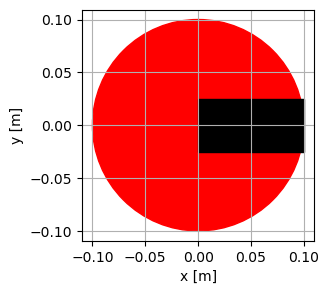

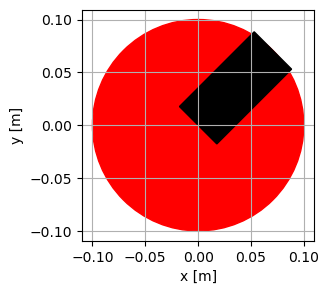

In [5]:
plt.figure(figsize=(3, 3))
plot_robot([0, 0, 0.0], robot_ray) # show the robot with an angle theta=0
plt.figure(figsize=(3, 3))
plot_robot([0, 0, np.pi/4], robot_ray) # show the robot with an angle theta=pi/4

In [6]:
def solve_base_problem(px_des, py_des, theta_des):
    opti, X, U = create_base_problem(x_init, [px_des, py_des, theta_des], u_min, u_max, w_u, N, dt)
    sol = opti.solve()
    x_sol = np.array([sol.value(X[k]) for k in range(N+1)]).T
    u_sol = np.array([sol.value(U[k]) for k in range(N)]).T

    plt.figure(figsize=(10, 4))
    plt.plot(x_sol[0,:], x_sol[1,:].T, 'x-', label='x', alpha=0.7)
    for k in range(1,N+1):
        plot_robot(x_sol[:,k], robot_ray, 'k', fill=0)
    plot_robot(x_init, robot_ray, 'b')
    plot_robot((px_des, py_des, theta_des), robot_ray)
    plt.legend()
    plt.show()

In [7]:
slider_px = FloatSlider(value=1, min=0, max=4, step=0.2, description='px des')
slider_py = FloatSlider(value=1, min=0, max=4, step=0.2, description='py des')
slider_th = FloatSlider(value=0, min=-np.pi, max=np.pi, step=np.pi/10, description='theta des')
interact(solve_base_problem, px_des=slider_px, py_des=slider_py, theta_des=slider_th);

interactive(children=(FloatSlider(value=1.0, description='px des', max=4.0, step=0.2), FloatSlider(value=1.0, …

## Questions
* What happens if you set $x_{des} = (4, 4, 0)$? Why?
* What happens if you set $x_{des} = (0, 1, 0)$? Why? How can you overcome this?

# Initial Guess
Let's give the solver an initial guess to help it get out of local minima.

In [8]:
def solve_base_problem_w_guess(px_des, py_des, theta_des):
    opti, X, U = create_base_problem(x_init, [px_des, py_des, theta_des], u_min, u_max, w_u, N, dt)

    # provide an initial guess for the state trajectory
    for k in range(N+1):
        opti.set_initial(X[k], [px_des, py_des, theta_des+1e-4])
    
    sol = opti.solve()
    x_sol = np.array([sol.value(X[k]) for k in range(N+1)]).T
    u_sol = np.array([sol.value(U[k]) for k in range(N)]).T

    plt.figure(figsize=(10, 4))
    plt.plot(x_sol[0,:], x_sol[1,:].T, 'x-', label='x', alpha=0.7)
    for k in range(1,N):
        plot_robot(x_sol[:,k], robot_ray, 'k', fill=0)
    plot_robot(x_init, robot_ray, 'b')
    plot_robot((px_des, py_des, theta_des), robot_ray)
    plt.legend()
    plt.show()

In [9]:
slider_px = FloatSlider(value=0, min=0, max=4, step=0.2, description='px des')
slider_py = FloatSlider(value=1, min=0, max=4, step=0.2, description='py des')
slider_th = FloatSlider(value=0, min=-np.pi, max=np.pi, step=np.pi/10, description='theta des')
interact(solve_base_problem_w_guess, px_des=slider_px, py_des=slider_py, theta_des=slider_th);

interactive(children=(FloatSlider(value=0.0, description='px des', max=4.0, step=0.2), FloatSlider(value=1.0, …

# Collision avoidance with circular obstacles
Let us now introduce an obstacle with circular shape in the environment. 
A 2D point $(x,y)$ belongs to a circle centered at $(c_x, c_y)$ with ray $r_o$ if it satisfies the inequality:
$$ \sqrt{(x-c_x)^2 + (y-c_y)^2} \le r_o$$

Assuming the robot has a circular shape with ray $r$, we can check collision between robot and obstacle by checking that their distance is greater than the sum of their radii:
$$ \sqrt{(p_x-c_x)^2 + (p_y-c_y)^2} \le r+r_o$$

Let's extend the optimal control problem to include this obstacle-avoidance constraint.

In [10]:
from matplotlib.patches import Ellipse
from ipywidgets import interact, fixed, FloatSlider

dt = 0.1                           # time step
N = 25                             # time horizon
x_init = np.zeros(nx)              # initial state
x_des = [2, 2, 3.14]               # target state
w_u = 1e-4                         # control weight
u_min = -2*np.ones(nu)             # minimum value of u
u_max = 2*np.ones(nu)              # maximum value of u
ray_robot = 0.1                    # ray of the robot

In [11]:
def solve_problem_w_obstacle(x_obst, y_obst, ray_obst, show_plot, return_sol):
    # create base problem w/o collision avoidance
    opti, X, U = create_base_problem(x_init, x_des, u_min, u_max, w_u, N, dt)
    
    # add collision avoidance constraints
    for k in range(1, N+1):
        d = X[k][:2] - np.array([x_obst, y_obst])
        opti.subject_to( cs.sqrt(d[0]**2 + d[1]**2) >= ray_obst+ray_robot)

    # solve the problem
    sol = opti.solve()
    x_sol = np.array([sol.value(X[k]) for k in range(N+1)]).T
    u_sol = np.array([sol.value(U[k]) for k in range(N)]).T

    plt.figure(figsize=(10, 4))
    plt.plot(x_sol[0,:], x_sol[1,:].T, 'x-', label='x', alpha=0.7)
    for k in range(1,N):
        plot_robot(x_sol[:,k], robot_ray, 'k', fill=0)
    plot_robot(x_init, robot_ray, 'b')
    plot_robot(x_des, robot_ray, 'r')
    plt.gca().add_patch(plt.Circle((x_obst, y_obst), ray_obst, color='k', label="Obstacle"))
    plt.legend()
    if(show_plot): 
        plt.show()
    if(return_sol):
        return x_sol, u_sol

In [12]:
interact(solve_problem_w_obstacle, x_obst=(0, 3, 0.2), y_obst=(0,3,0.2), ray_obst=(0.1, 0.5, 0.1), 
         show_plot=fixed(True), return_sol=fixed(False));

interactive(children=(FloatSlider(value=1.0, description='x_obst', max=3.0, step=0.2), FloatSlider(value=1.0, …

## Questions
* What happens if you move the obstacle in (2, 2)?
* What happens if you move the obstacle in (0, 0)? Why? How can we fix this?
* What happens if you check collisions in-between time steps?

Collision detected at time step 10. Margin: -0.02679353015537314


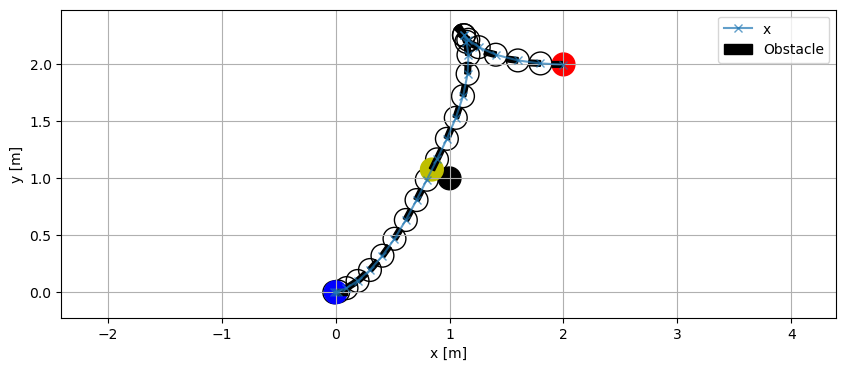

In [13]:
x_obst, y_obst, ray_obst = 1, 1, 0.1
X, U = solve_problem_w_obstacle(x_obst, y_obst, ray_obst, show_plot=False, return_sol=True)
from math import sqrt
for k in range(N):
    x = 0.5*(X[:,k]+X[:,k+1]) # compute state in-between time steps
    d = x[:2] - np.array([x_obst, y_obst]) 
    margin = sqrt(d[0]**2 + d[1]**2) - (ray_obst+ray_robot)
    if(margin<0.0): # check collision
        print(f"Collision detected at time step {k}. Margin: {margin}")
        plot_robot(x, ray_robot, color1='y') # display a yellow robot when it collides
plt.show()

# How to ensure collision avoidance in continuous time?

* Add safety margin (hard to know how much)
* Decrease time step
* Add extra constraints in-between time steps
* Check collisions with convex hull of robot shapes between consecutive time steps

# Collision avoidance with polygonal obstacles
What if some obstacles (or the robot) are not well approximated by a circle?

A convex polygon is defined by a set of $K$ vertices $v_i = (x_i, y_i)$, $\forall i\in [0, K-1]$.

How can we check if a point $p=(p_x, p_y)$ does not collide with a polygon?

### Option 1
Try to express $p$ as a convex combination of the vertices:
$$ p = \sum_{i=0}^{K-1} v_i \, \lambda_i, $$
with:
$$ \sum_{i=0}^{K-1} \lambda_i = 1, \qquad \lambda_i \ge 0 \quad \forall i \in [0, K-1]$$
If a solution $\lambda$ does not exist then it means that $p$ does not collide with the polygon.

This is **not usable** because it requires the solver to fail to find a solution to certify collision avoidance.

### Option 2
Try to find a line that separates $p$ and the vertices:
$$ a^T p + b \ge 0 \qquad \qquad \qquad \qquad$$
$$ a^T v_i + b < 0, \qquad \forall i \in [0, K-1]$$
$$ ||a||^2 = 1 \qquad \qquad \qquad \qquad$$
If such values of $a$ and $b$ exist, then $p$ does not collide with the polygon.

This is **usable** because to certify collision avoidance the solver must find a solution.

In [14]:
from matplotlib.patches import Polygon

In [15]:
def check_collision(p_x, p_y, V):
    p = np.array([p_x, p_y])
    # create optimization problem
    opti = cs.Opti()
    # Create the decision variables a and b
    a, b = opti.variable(2), opti.variable(1)
    opti.subject_to(a.T @ p + b >= 0.0)
    for i in range(len(V)):
        opti.subject_to(a.T @ V[i] + b < 0.0)
    opti.subject_to(a.T @ a == 1) # ensure a has unit norm

    # create the optimization solver
    opti.solver("ipopt", {"ipopt.print_level": 0, "print_time": 0})
    try: # try to solve the problem
        sol = opti.solve()
        a_sol, b_sol = sol.value(a), sol.value(b)
        collision = False
    except:
#         print("Solver has failed:", opti.debug.stats()['return_status'])
        sol = opti.debug
        a_sol, b_sol = None, None
        collision = True
        
    return collision, a_sol, b_sol

In [16]:
def check_collision_and_plot(p_x, p_y, V):    
    collision, a, b = check_collision(p_x, p_y, V)

    if(not collision): # plot the line
        X = np.linspace(-1, 1, 2)
        plt.plot(X, (a[0]*X + b)/(-a[1]), label="a*x+b")

    # plot the polygon and its vertices
    plt.gca().add_patch(Polygon(np.array(V)))
    for i in range(len(V)):
        plt.plot(V[i][0], V[i][1], 'k o', markersize=5, label="vertex")
    
    # plot the point
    if(collision): # red if in collision
        plt.plot(p_x, p_y, 'r v', markersize=10, label='point in collision')
    else: # blue if not in collision
        plt.plot(p_x, p_y, 'b v', markersize=10, label='point not in collision')

    plt.grid(True)
    plt.legend()
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.show()

In [17]:
# define the list of vertices of the obstacle
V = []
V.append(np.array([ 0.3,  0.4]))
V.append(np.array([ 0.5,  0.0]))
V.append(np.array([ 0.3, -0.3]))
V.append(np.array([-0.3, -0.2]))
V.append(np.array([-0.3,  0.3]))

In [18]:
interact(check_collision_and_plot, p_x=(-1,1,0.05), p_y=(-1,1,0.05), V=fixed(V))

interactive(children=(FloatSlider(value=0.0, description='p_x', max=1.0, min=-1.0, step=0.05), FloatSlider(val…

<function __main__.check_collision_and_plot(p_x, p_y, V)>

# Checking collision between a polygon and a sphere
Since the robot is modeled as a sphere, we need to check collision between a sphere and a polygon.
We can easily extend the method used above. 

Assume the robot is in position $p$ and its ray has length $r$. Collision avoidance is ensured if the following constraints admit a solution:
$$ a^T p + b \ge r \qquad \qquad \qquad \qquad$$
$$ a^T v_i + b < 0, \qquad \forall i \in [0, K-1]$$
$$ ||a||^2 = 1 \qquad \qquad \qquad \qquad$$

Let's solve a trajectory optimization problem with polygonal obstacles.

In [19]:
dt = 0.1                           # time step
N = 25                             # time horizon
x_init = np.zeros(nx)              # initial state
x_des = [2, 2, 3.14]               # target state
w_u = 1e-4                         # control weight
u_min = -2*np.ones(nu)             # minimum value of u
u_max = 2*np.ones(nu)              # maximum value of u
ray_robot = 0.1                    # ray of the robot

In [20]:
def solve_problem_w_poly_obst(V_obst, show_plot, return_sol):
    # create base problem w/o collision avoidance
    opti, X, U = create_base_problem(x_init, x_des, u_min, u_max, w_u, N, dt)
    
    # add collision avoidance constraints
    for k in range(1, N+1):
        a, b = opti.variable(2), opti.variable(1)
        opti.subject_to( a.T @ a == 1)
        opti.subject_to( a.T @ X[k][:2] + b >= ray_robot)
        for i in range(V_obst.shape[0]):
            opti.subject_to( a.T @ V_obst[i,:].T + b < 0.0)

    # solve the problem
    sol = opti.solve()
    x_sol = np.array([sol.value(X[k]) for k in range(N+1)]).T
    u_sol = np.array([sol.value(U[k]) for k in range(N)]).T

    plt.figure(figsize=(10, 4))
    plt.plot(x_sol[0,:], x_sol[1,:].T, 'x-', label='x', alpha=0.7)
    for k in range(1,N+1):
        plot_robot(x_sol[:,k], robot_ray, 'k', fill=0)
    plot_robot(x_init, robot_ray, 'b')
    plot_robot(x_des, robot_ray, 'r')
    plt.gca().add_patch(Polygon(V_obst, color='k', label="Obstacle"))
    plt.legend()
    if(show_plot): 
        plt.show()
    if(return_sol):
        return x_sol, u_sol

In [21]:
# define the list of vertices of the obstacle
V = []
V.append(np.array([ 0.3,  0.4]))
V.append(np.array([ 0.5,  0.0]))
V.append(np.array([ 0.3, -0.3]))
V.append(np.array([-0.3, -0.2]))
V.append(np.array([-0.3,  0.3]))
V = np.array(V)

def poly_obst_interactive(x_obst, y_obst):
    V_obst = V + np.array([x_obst, y_obst])
    solve_problem_w_poly_obst(V_obst, show_plot=True, return_sol=False)

In [22]:
interact(poly_obst_interactive, x_obst=(0.2, 2, 0.2), y_obst=(0.2, 2, 0.2));

interactive(children=(FloatSlider(value=1.0, description='x_obst', max=2.0, min=0.2, step=0.2), FloatSlider(va…

# Summary
* We can **quickly** optimize trajectories to reach a target while **avoiding an obstacle**
* **Multiple obstacles** could be considered at once
* Robot/obstacles can have either **circular** or **polygonal** shapes
* Constraints are only ensured at **discrete time steps**
* Solvers can fall in bad **local minima**
* **Initial guesses** can help the solver

# Extensions
### Robustness
* Introduce safety margin $s\ge0$ as decision variable
* Maximize $s$ in cost function
* Add safety margin in collision avoidance constraints, e.g.: $ a^T p + b \ge r +s$

### Smoothness
* How can we ensure continuous velocities/accelerations?
* Increase dynamics order
    * Include velocities in state:
$$ x = [p_x, p_y, \theta, v, \omega]$$
    * Accelerations become the new control inputs:
$$ u = [\dot{v}, \dot{\omega}]$$